In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import cftime
import datetime
from datetime import date
from matplotlib import pyplot
from matplotlib import colors
from matplotlib import font_manager
from matplotlib.cm import ScalarMappable
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
import numpy
import pandas
from PIL import Image
import random
import xarray as xr

In [2]:
Diri = '/glade/u/home/whimkao//ExtraTrack/ExtraTrack_Data/Output_Files_V6/'
Output_Diri = '/glade/u/home/whimkao//ExtraTrack/ExtraTrack_Github/RCP_Figs/Analysis_Figs_V6.4.2/'

In [3]:
# Open File
def Open_File(File):
    DF = pandas.read_csv(File)
    DF = DF.drop("Unnamed: 0", axis=1)
    return (DF)

In [4]:
# Open Each File
def Files_Open(Model, Diri):
    Data_DF = Open_File(Diri+Model+'_Data_SubsetA_Output_V6.csv')
    ET_DF = Open_File(Diri+Model+'_ET_SubsetA_Output_V6.csv')
    Codes_DF = Open_File(Diri+Model+'_Codes_Output_V6.csv')
    Time, Begin_Time, Compl_Time, Peak_Time = [], [], [], []
# Edit Time Format
    for i in range(len(Data_DF)):
        Time.append(Datetime(Data_DF["Time(Z)"][i]))
    for j in range(len(ET_DF)):
        Begin_Time.append(Datetime(ET_DF["ET Begin Time"][j]))
        Compl_Time.append(Datetime(ET_DF["ET Complete Time"][j]))
        Peak_Time.append(Datetime(ET_DF["Peak Time"][j]))
    Data_DF["Time(Z)"] = Time
    ET_DF["ET Begin Time"] = Begin_Time
    ET_DF["ET Complete Time"] = Compl_Time
    ET_DF["Peak Time"] = Peak_Time
    return (Data_DF, ET_DF, Codes_DF)

In [5]:
def Datetime(Time):
    try:
        New_Time = datetime.datetime.strptime(Time, '%Y-%m-%d %H:%M:%S')
    except:
        New_Time = numpy.nan
    return (New_Time)

In [6]:
# Create Phase Distribution Bins
def Create_Bins(Min, Max, Bin_Width):
    Bins = numpy.arange(Min, Max+Bin_Width, Bin_Width)
    return (Bins)
Lat_Bins = Create_Bins(10,60,5)
Lon_Bins = Create_Bins(-100,20,5)

In [7]:
Num_Years = numpy.array([90,93,93])

In [8]:
Control_Data, Control_ET, Control_Codes = Files_Open("Control", Diri)
RCP45_Data, RCP45_ET, RCP45_Codes = Files_Open("RCP45", Diri)
RCP85_Data, RCP85_ET, RCP85_Codes = Files_Open("RCP85", Diri)

In [9]:
# Create Function to Plot ET Begin and Complete Locations
def Plot_ET_Locs(ET_DF, Model, i):
#
# Plot Peak Locations
    Axis = Fig.add_subplot(3,3,3*i+1, projection=ccrs.PlateCarree())
    Peak_Lons = ET_DF["Peak Lon"]
    Peak_Lats = ET_DF["Peak Lat"]
    for k in range(len(Peak_Lats)):
        pyplot.scatter(Peak_Lons[k], Peak_Lats[k], marker='*', linewidths=1.8, \
        facecolors='none', edgecolors='black', s=28)
    Plot_Map_Formatting(Axis)
    Title = Model + ": Storm Peak Locations"
    Axis.set_title(Title, fontsize=24)
#
# Plot ET Begin Locations
    Axis = Fig.add_subplot(3,3,3*i+2, projection=ccrs.PlateCarree())
    Begin_Lons = ET_DF["ET Begin Lon"]
    Begin_Lats = ET_DF["ET Begin Lat"]
    for k in range(len(Begin_Lats)):
        pyplot.scatter(Begin_Lons[k], Begin_Lats[k], marker='s', linewidths=1.8, \
        facecolors='none', edgecolors='black', s=28)
    Plot_Map_Formatting(Axis)
    Title = Model + ": ET Initiation Locations"
    Axis.set_title(Title, fontsize=24)
#
# Plot ET Complete Data
    Axis = Fig.add_subplot(3,3,3*i+3, projection=ccrs.PlateCarree())
    Compl_Lons = ET_DF["ET Complete Lon"]
    Compl_Lats = ET_DF["ET Complete Lat"]
    for k in range(len(Compl_Lats)):
        pyplot.scatter(Compl_Lons[k], Compl_Lats[k], marker='^', linewidths=1.8, \
        facecolors='none', edgecolors='black', s=28)
    Plot_Map_Formatting(Axis)
    Title = Model + ": ET Completion Locations"
    Axis.set_title(Title, fontsize=24)

In [10]:
def Plot_Map_Formatting(Axis):
    Axis.coastlines(linewidth=0.5)
    Axis.add_feature(cfeature.BORDERS, linewidth=0.5)
    Axis.add_feature(cfeature.STATES, linewidth=0.3)
    x_Min, x_Max, y_Min, y_Max = -100, 20, 10, 60
    x_Axis = Create_Bins(x_Min, x_Max, 10)
    y_Axis = Create_Bins(y_Min, y_Max, 10)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    Axis.set_xlim(x_Min,x_Max)
    Axis.set_ylim(y_Min,y_Max)
    Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')

In [11]:
# Create Function to Calculate ET Locations Spatial Distribution
def ET_Locs_Distr(ET_DF, Lat_Bins, Lon_Bins, Model, Rela):
# Count ET Locations Distribution
    Length = len(ET_DF)
    Begin_Count = ET_Loc_Count(ET_DF, True, Lat_Bins, Lon_Bins, 5, 5)
    Compl_Count = ET_Loc_Count(ET_DF, False, Lat_Bins, Lon_Bins, 5, 5)
#
# Calculate ET Locations Density
    if Rela == True:
        Begin_Density = Begin_Count / Length * 100
        Compl_Density = Compl_Count / Length * 100
        return (Begin_Density, Compl_Density)
#
# Calculate ET Locations Annual
    else:
        if Model == "Control":
            Num_Year = 90
        else:
            Num_Year = 93
        Begin_Annual = Begin_Count / Num_Year * 100
        Compl_Annual = Compl_Count / Num_Year * 100
        return (Begin_Annual, Compl_Annual)

In [12]:
# Count ET Locations Distribution
def ET_Loc_Count(ET_DF, Begin, Lat_Bins, Lon_Bins, Param_Lat, Param_Lon):
    Lat_Lon_Count = numpy.zeros((len(Lat_Bins), len(Lon_Bins)))
    if Begin == True:
        Lat_Var = "ET Begin Lat"
        Lon_Var = "ET Begin Lon"
    else:
        Lat_Var = "ET Complete Lat"
        Lon_Var = "ET Complete Lon"
#
# Count Lat Lon Distribution
    for i in range(len(Lat_Bins)):
        for j in range(len(Lon_Bins)):
            Lat_Min = Lat_Bins[i] - Param_Lat
            Lat_Max = Lat_Bins[i] + Param_Lat
            Lon_Min = Lon_Bins[j] - Param_Lon
            Lon_Max = Lon_Bins[j] + Param_Lon
            Lat_Lon_Count[i][j] = Create_Sub_DF(ET_DF, Lat_Var, Lon_Var, Lat_Min, Lat_Max, Lon_Min, Lon_Max)
    return (Lat_Lon_Count)

In [13]:
def Create_Sub_DF(ET_DF, Lat, Lon, Lat_Min, Lat_Max, Lon_Min, Lon_Max):
    ET_Subset = ET_DF[(ET_DF[Lat] >= Lat_Min) & (ET_DF[Lat] <= Lat_Max) & \
    (ET_DF[Lon] >= Lon_Min) & (ET_DF[Lon] <= Lon_Max)]
    return (len(ET_Subset))

In [14]:
# Create Function For ET Spatial Distribution Count Colours
Spatial_Colours = ['lightskyblue', 'deepskyblue', 'limegreen', 'greenyellow', 'yellow', 'orange', 'red']
ET_Rela_Bounds = numpy.array([0.0001,2,4,6,8,10,12])
ET_Annual_Bounds = numpy.array([0.0001,5,10,15,20,25,30])

In [15]:
# Create Function to Plot ET Begin and Complete Locations
def ET_Distr_Plot(ET_DF, Model, Rela, i, Colourbar):
    Lat_Bins = Create_Bins(10,60,1)
    Lon_Bins = Create_Bins(-100,10,1)
# Use Function to Calculate Distributions
    Spatial_Begin, Spatial_Compl = ET_Locs_Distr(ET_DF, Lat_Bins, Lon_Bins, Model, Rela)
#
# Define Colours and Bounds
    if Rela == True:
        Bounds = ET_Rela_Bounds
        Colours = Spatial_Colours
    else:
        Bounds = ET_Annual_Bounds
        Colours = Spatial_Colours
#
# Plot ET Begin Distrbution
    Axis = Fig.add_subplot(3,2,i*2+1, projection=ccrs.PlateCarree())
    pyplot.contourf(Lon_Bins, Lat_Bins, Spatial_Begin, levels=Bounds, colors=Colours, extend='max')
    Plot_Map_Formatting(Axis)
    Title = Model + ": ET Initiation Distribution"
    Axis.set_title(Title, fontsize=20)
#
# Colour Bar
    if Colourbar == True:
        if Rela == True:
            Cbar_Label = 'Frequency (Per 1000 Data Points)'
        else:
            Cbar_Label = 'Frequency (Per 100 Years)'
        C_Map = mcolors.LinearSegmentedColormap.from_list("Frequency of Locations", Colours, N=len(Colours))
        Norm = mcolors.BoundaryNorm(Bounds, C_Map.N, extend='max')
        Cax = Axis.inset_axes([0.1, -0.14, 0.8, 0.05], transform=Axis.transAxes)
        Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='horizontal', cax=Cax, ticks=Bounds, \
        label=Cbar_Label)
#
# Plot ET Complete Distribution
    Axis = Fig.add_subplot(3,2,i*2+2, projection=ccrs.PlateCarree())
    pyplot.contourf(Lon_Bins, Lat_Bins, Spatial_Compl, levels=Bounds, colors=Colours, extend='max')
    Plot_Map_Formatting(Axis)
    Title = Model + ": ET Completion Distribution"
    Axis.set_title(Title, fontsize=20)

In [27]:
# Calculate Difference Between Models
def ET_Locs_Diff(ET_DF_1, ET_DF_2, Model_1, Model_2, Lat_Bins, Lon_Bins, Rela):
    Begin_1, Compl_1 = ET_Locs_Distr(ET_DF_1, Lat_Bins, Lon_Bins, Model_1, Rela)
    Begin_2, Compl_2 = ET_Locs_Distr(ET_DF_2, Lat_Bins, Lon_Bins, Model_2, Rela)
    Begin_Diff = Begin_1 - Begin_2
    Compl_Diff = Compl_1 - Compl_2
    return (Begin_Diff, Compl_Diff)

In [28]:
# Create Function of Colours of ET Locations Difference Plots
Diff_Colours = ['mediumblue', 'deepskyblue', 'cyan', 'lawngreen', \
'gold', 'darkorange', 'red']
ET_Rela_Diff_Bounds = numpy.array([-3,-2,-1,1,2,3])
ET_Annual_Diff_Bounds = numpy.array([-30,-20,-10,10,20,30])

In [29]:
# Create Function to Plot ET Begin and Complete Locations
def ET_Diff_Plot(ET_DF_1, ET_DF_2, Model_1, Model_2, Rela, i, Colourbar):
    Lat_Bins = Create_Bins(10,60,1)
    Lon_Bins = Create_Bins(-100,10,1)
    Begin_Diff, Compl_Diff = ET_Locs_Diff(ET_DF_1, ET_DF_2, Model_1, Model_2, Lat_Bins, Lon_Bins, Rela)
#
# Define Colours and Bounds
    if Rela == True:
        Bounds = ET_Rela_Diff_Bounds
    else:
        Bounds = ET_Annual_Diff_Bounds
    Colours = Diff_Colours
#
# Plot ET Begin Distrbution
    Axis = Fig.add_subplot(3,2,i*2+1, projection=ccrs.PlateCarree())
    pyplot.contourf(Lon_Bins, Lat_Bins, Begin_Diff, levels=Bounds, colors=Colours, extend='both')
    Plot_Map_Formatting(Axis)
    if Rela == True:
        Type = "Relative"
    else:
        Type = "Annual"
    Title = Model_1 + " - " + Model_2 + ": Diff in ET Initiation Distribution"
    Axis.set_title(Title, fontsize=20)
#
# Colour Bar
    if Colourbar == True:
        if Rela == True:
            Cbar_Label = 'Frequency Diff (Per 1000 Data Points)'
        else:
            Cbar_Label = 'Frequency Diff (Per 100 Years)'
        C_Map = mcolors.LinearSegmentedColormap.from_list("Frequency of Locations", Colours, N=len(Colours))
        Norm = mcolors.BoundaryNorm(Bounds, C_Map.N, extend='both')
        Cax = Axis.inset_axes([0.1, -0.14, 0.8, 0.05], transform=Axis.transAxes)
        Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='horizontal', cax=Cax, ticks=Bounds, \
        label=Cbar_Label)
#
# Plot ET Complete Distribution
    Axis = Fig.add_subplot(3,2,i*2+2, projection=ccrs.PlateCarree())
    pyplot.contourf(Lon_Bins, Lat_Bins, Compl_Diff, levels=Bounds, colors=Colours, extend='both')
    Plot_Map_Formatting(Axis)
    Title = Model_1 + " - " + Model_2 + ": Diff in ET Completion Distribution"
    Axis.set_title(Title, fontsize=20)

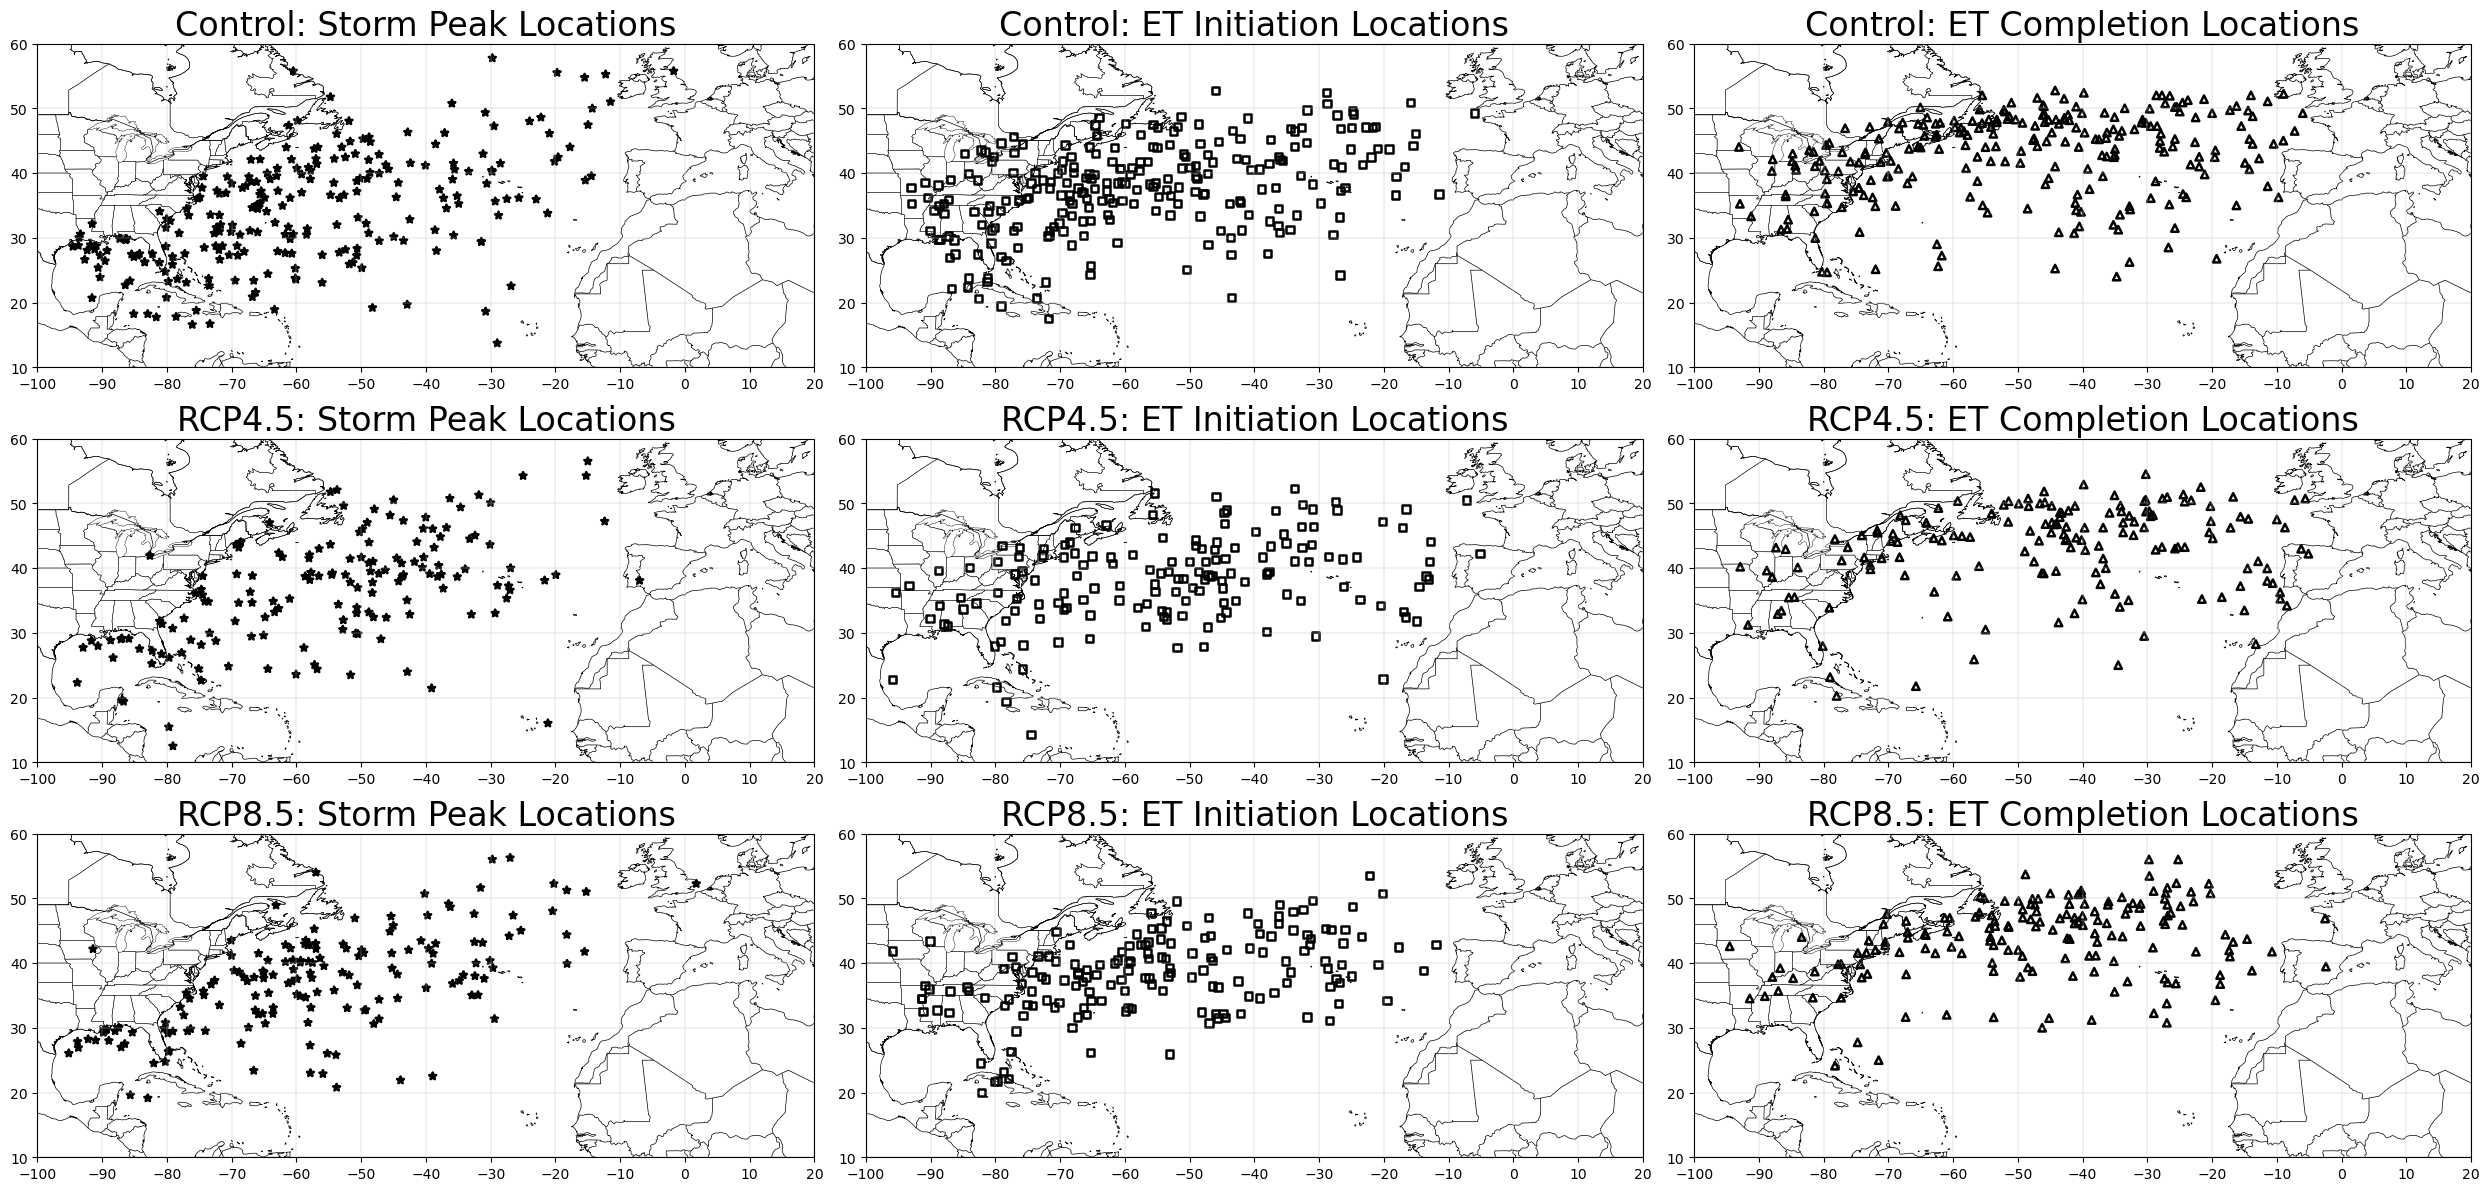

In [19]:
# Plot Storm Peak, ET Initiation and ET Completion Locations
Fig = pyplot.figure(figsize=(25,12))
Plot_ET_Locs(Control_ET, "Control", 0)
Plot_ET_Locs(RCP45_ET, "RCP4.5", 1)
Plot_ET_Locs(RCP85_ET, "RCP8.5", 2)
Fig.tight_layout()
Fig.savefig(Output_Diri+'ET_Loc.png', bbox_inches='tight')

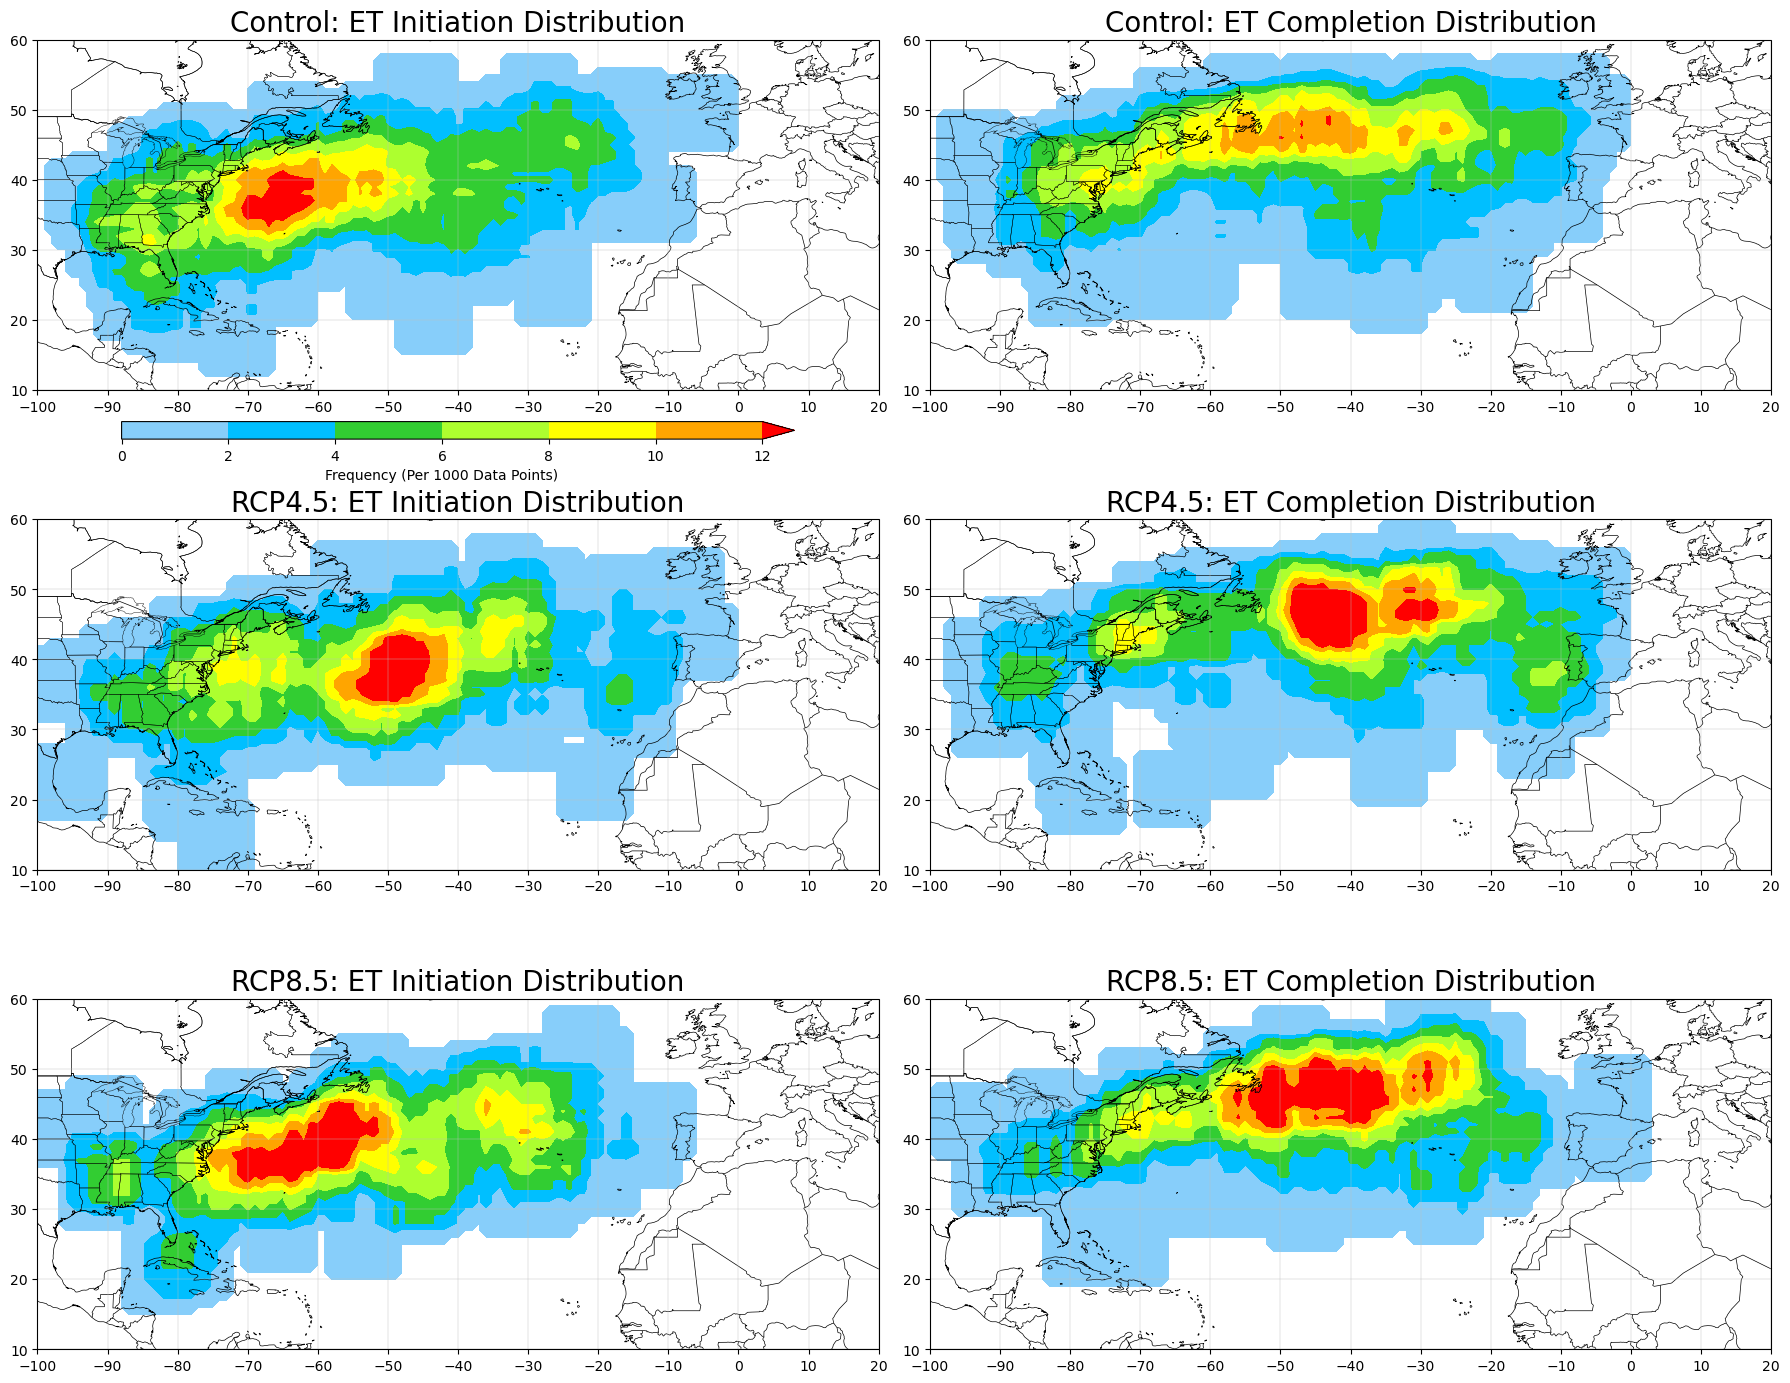

In [20]:
# Plot ET Initiation and Completion Spatial Distributions (Relative)
Fig = pyplot.figure(figsize=(18,14))
ET_Distr_Plot(Control_ET, "Control", True, 0, True)
ET_Distr_Plot(RCP45_ET, "RCP4.5", True, 1, False)
ET_Distr_Plot(RCP85_ET, "RCP8.5", True, 2, False)
Fig.tight_layout()
Fig.savefig(Output_Diri+'ET_Distr_Rela.png', bbox_inches='tight')

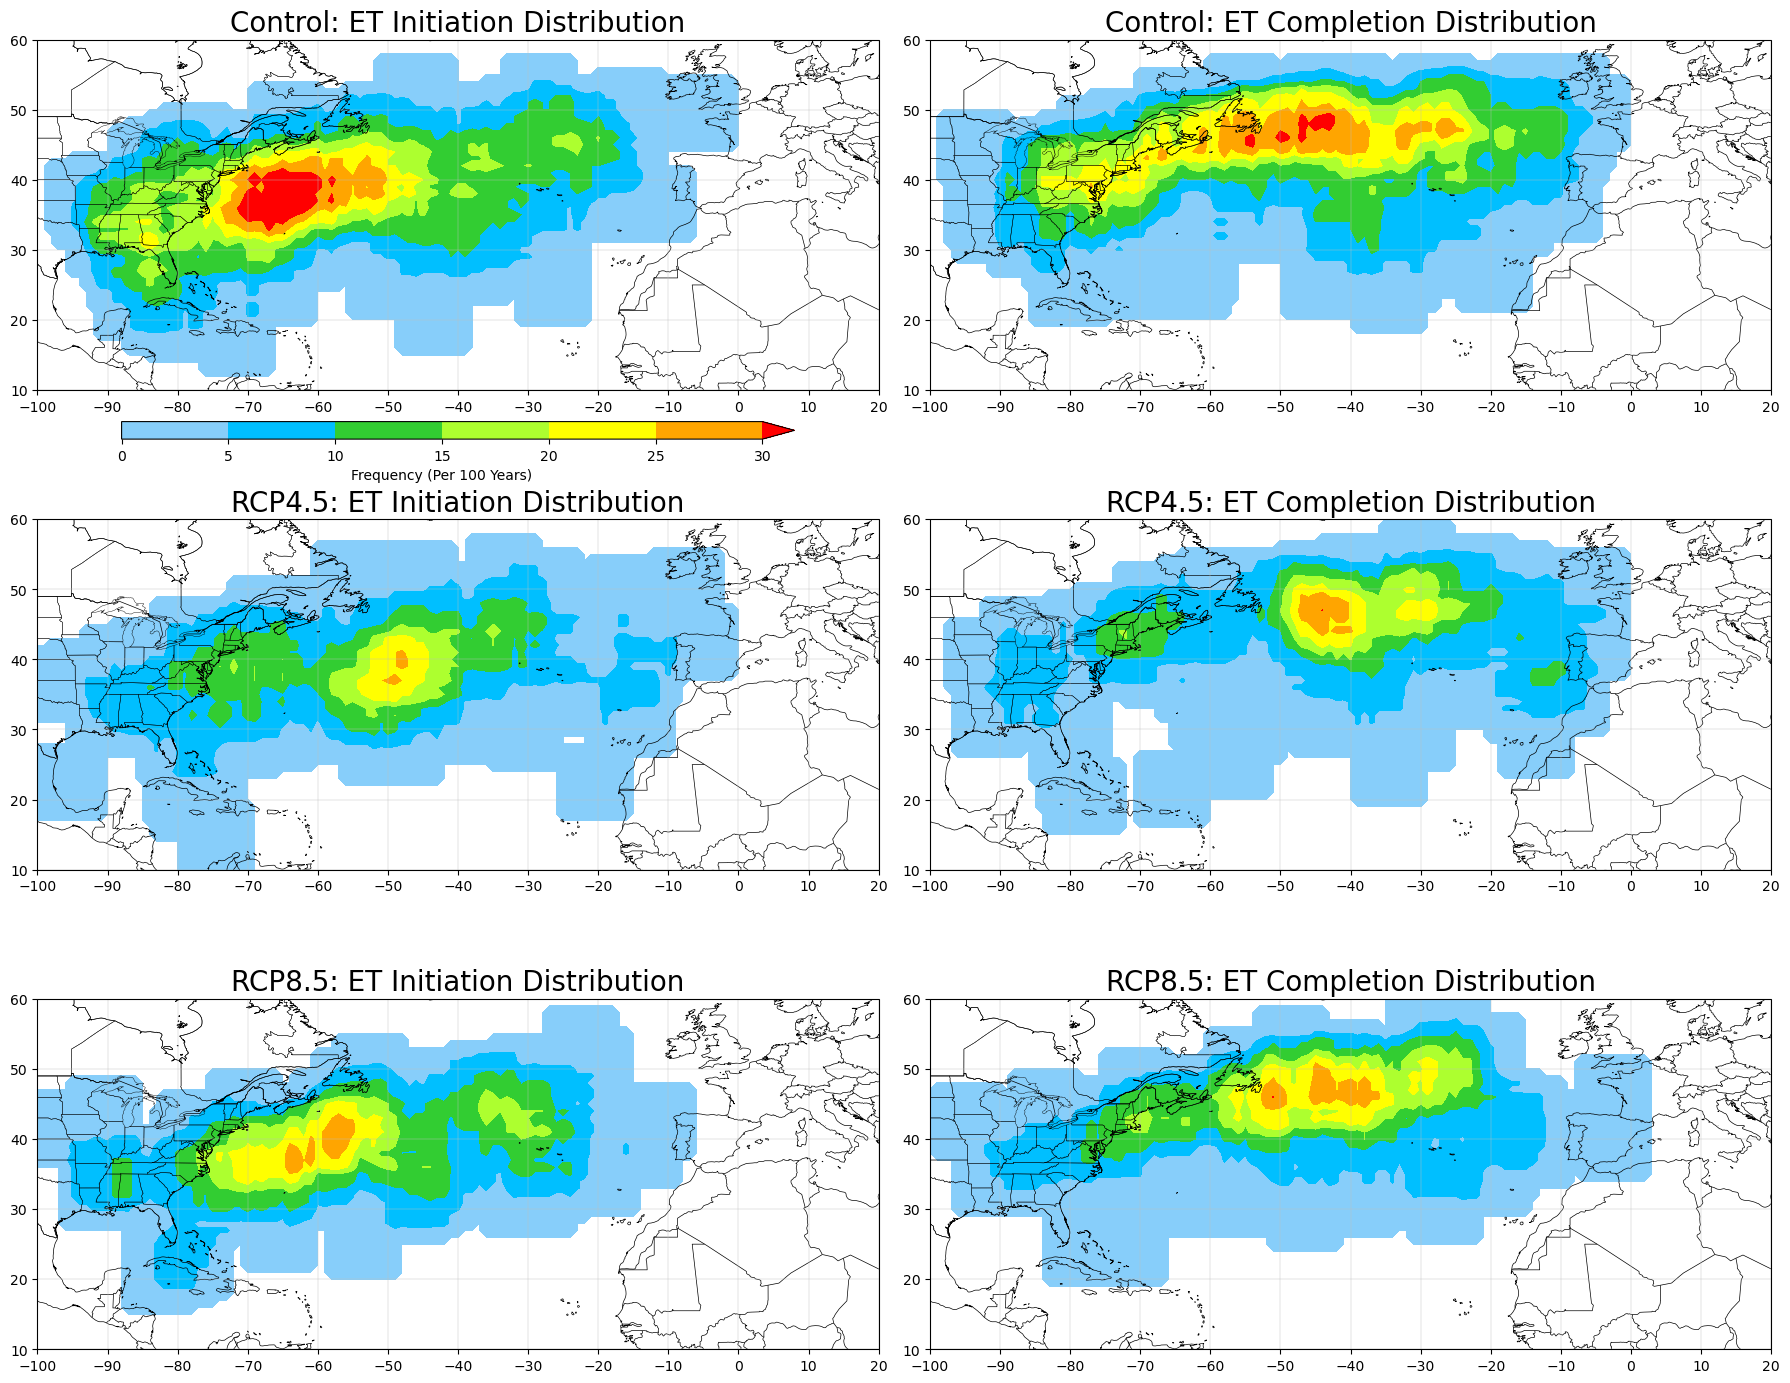

In [21]:
# Plot ET Initiation and Completion Spatial Distributions (Annual)
Fig = pyplot.figure(figsize=(18,14))
ET_Distr_Plot(Control_ET, "Control", False, 0, True)
ET_Distr_Plot(RCP45_ET, "RCP4.5", False, 1, False)
ET_Distr_Plot(RCP85_ET, "RCP8.5", False, 2, False)
Fig.tight_layout()
Fig.savefig(Output_Diri+'ET_Distr_Annual.png', bbox_inches='tight')

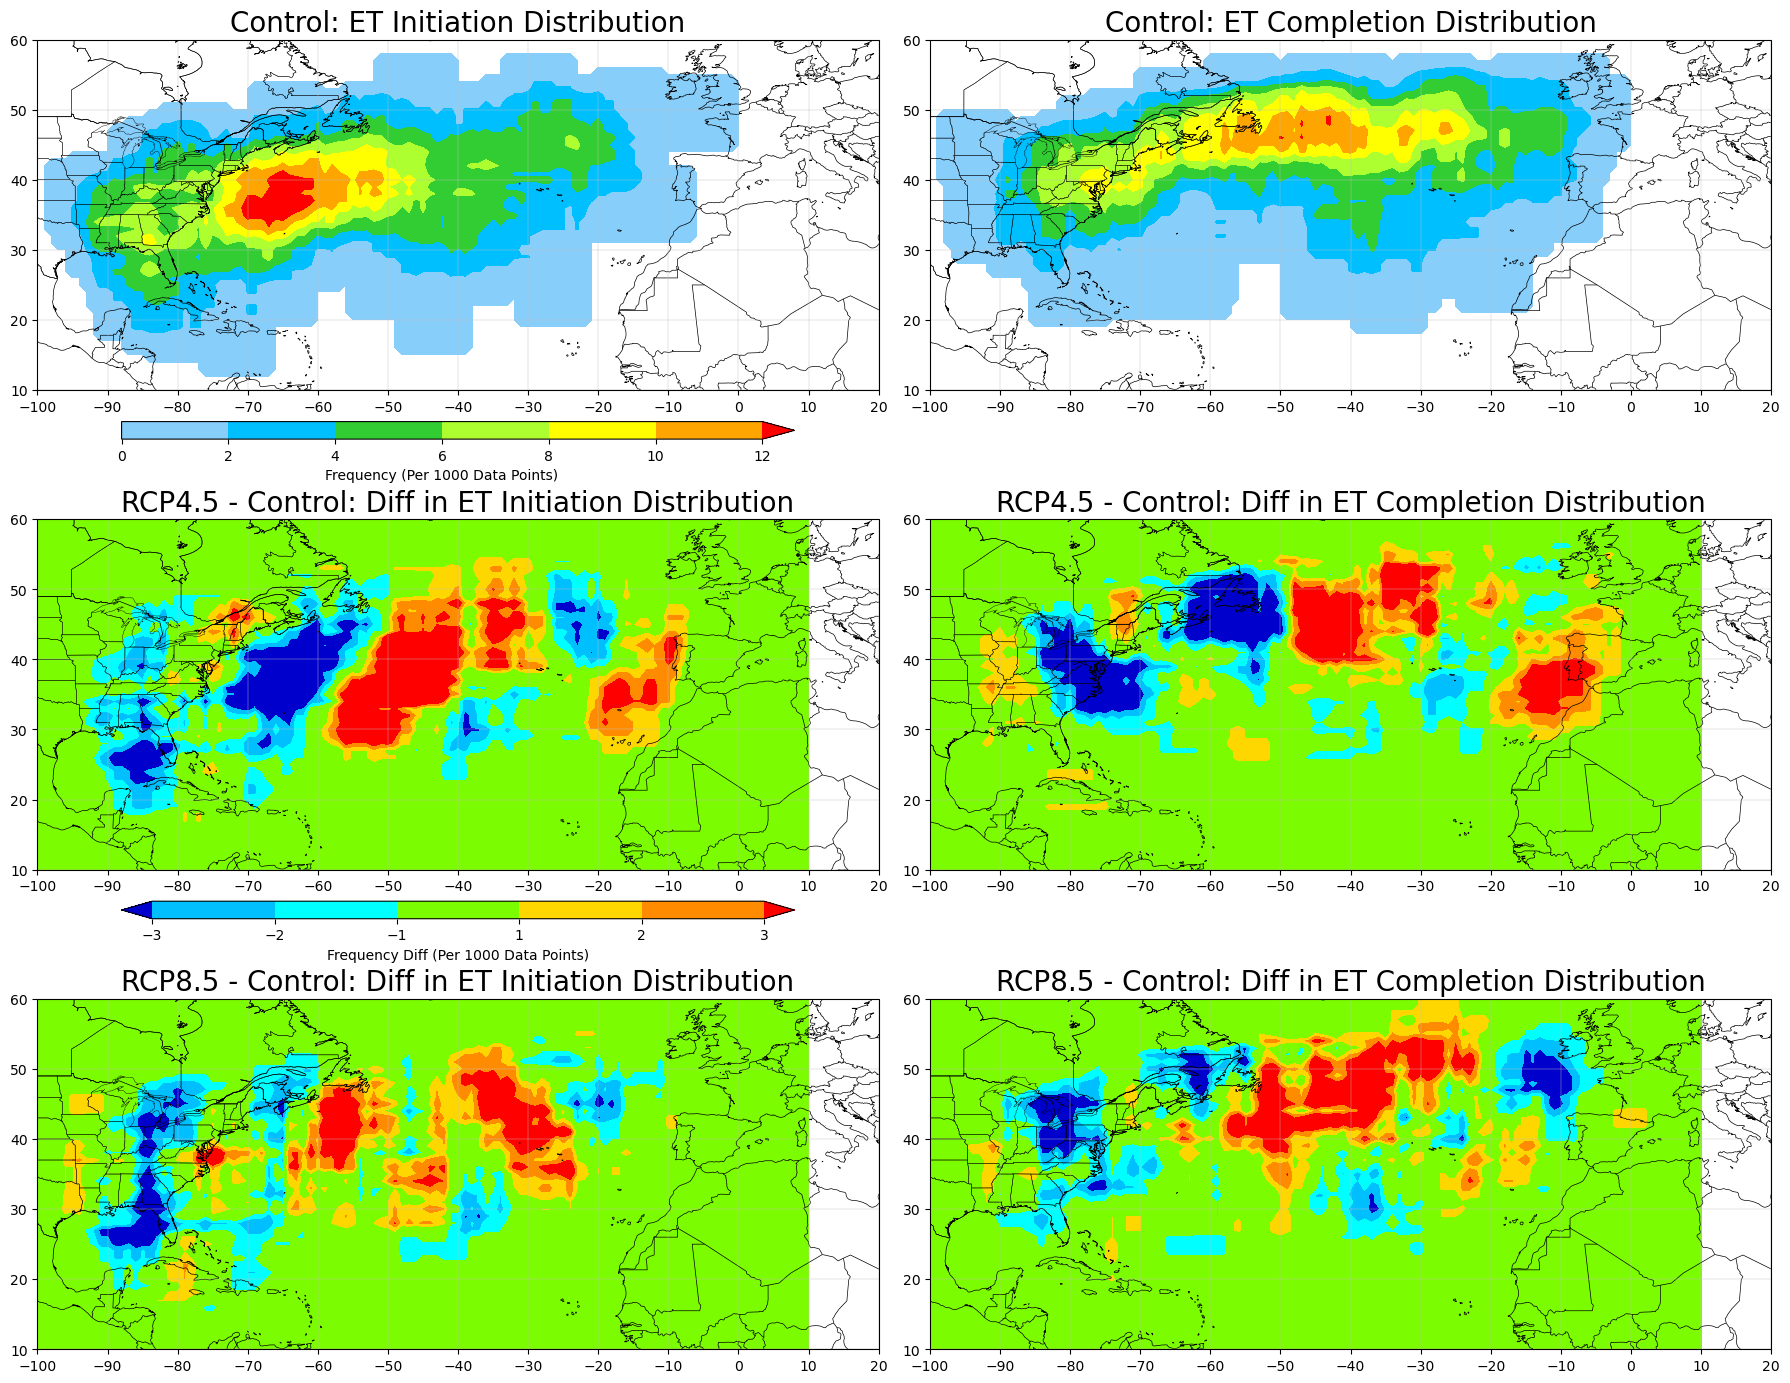

In [30]:
# Plot Differences Between ET Initiation and Completion Spatial Distributions (Relative)
Fig = pyplot.figure(figsize=(18,14))
ET_Distr_Plot(Control_ET, "Control", True, 0, True)
ET_Diff_Plot(RCP45_ET, Control_ET, "RCP4.5", "Control", True, 1, True)
ET_Diff_Plot(RCP85_ET, Control_ET, "RCP8.5", "Control", True, 2, False)
Fig.tight_layout()
Fig.savefig(Output_Diri+'ET_Diff_Rela.png', bbox_inches='tight')

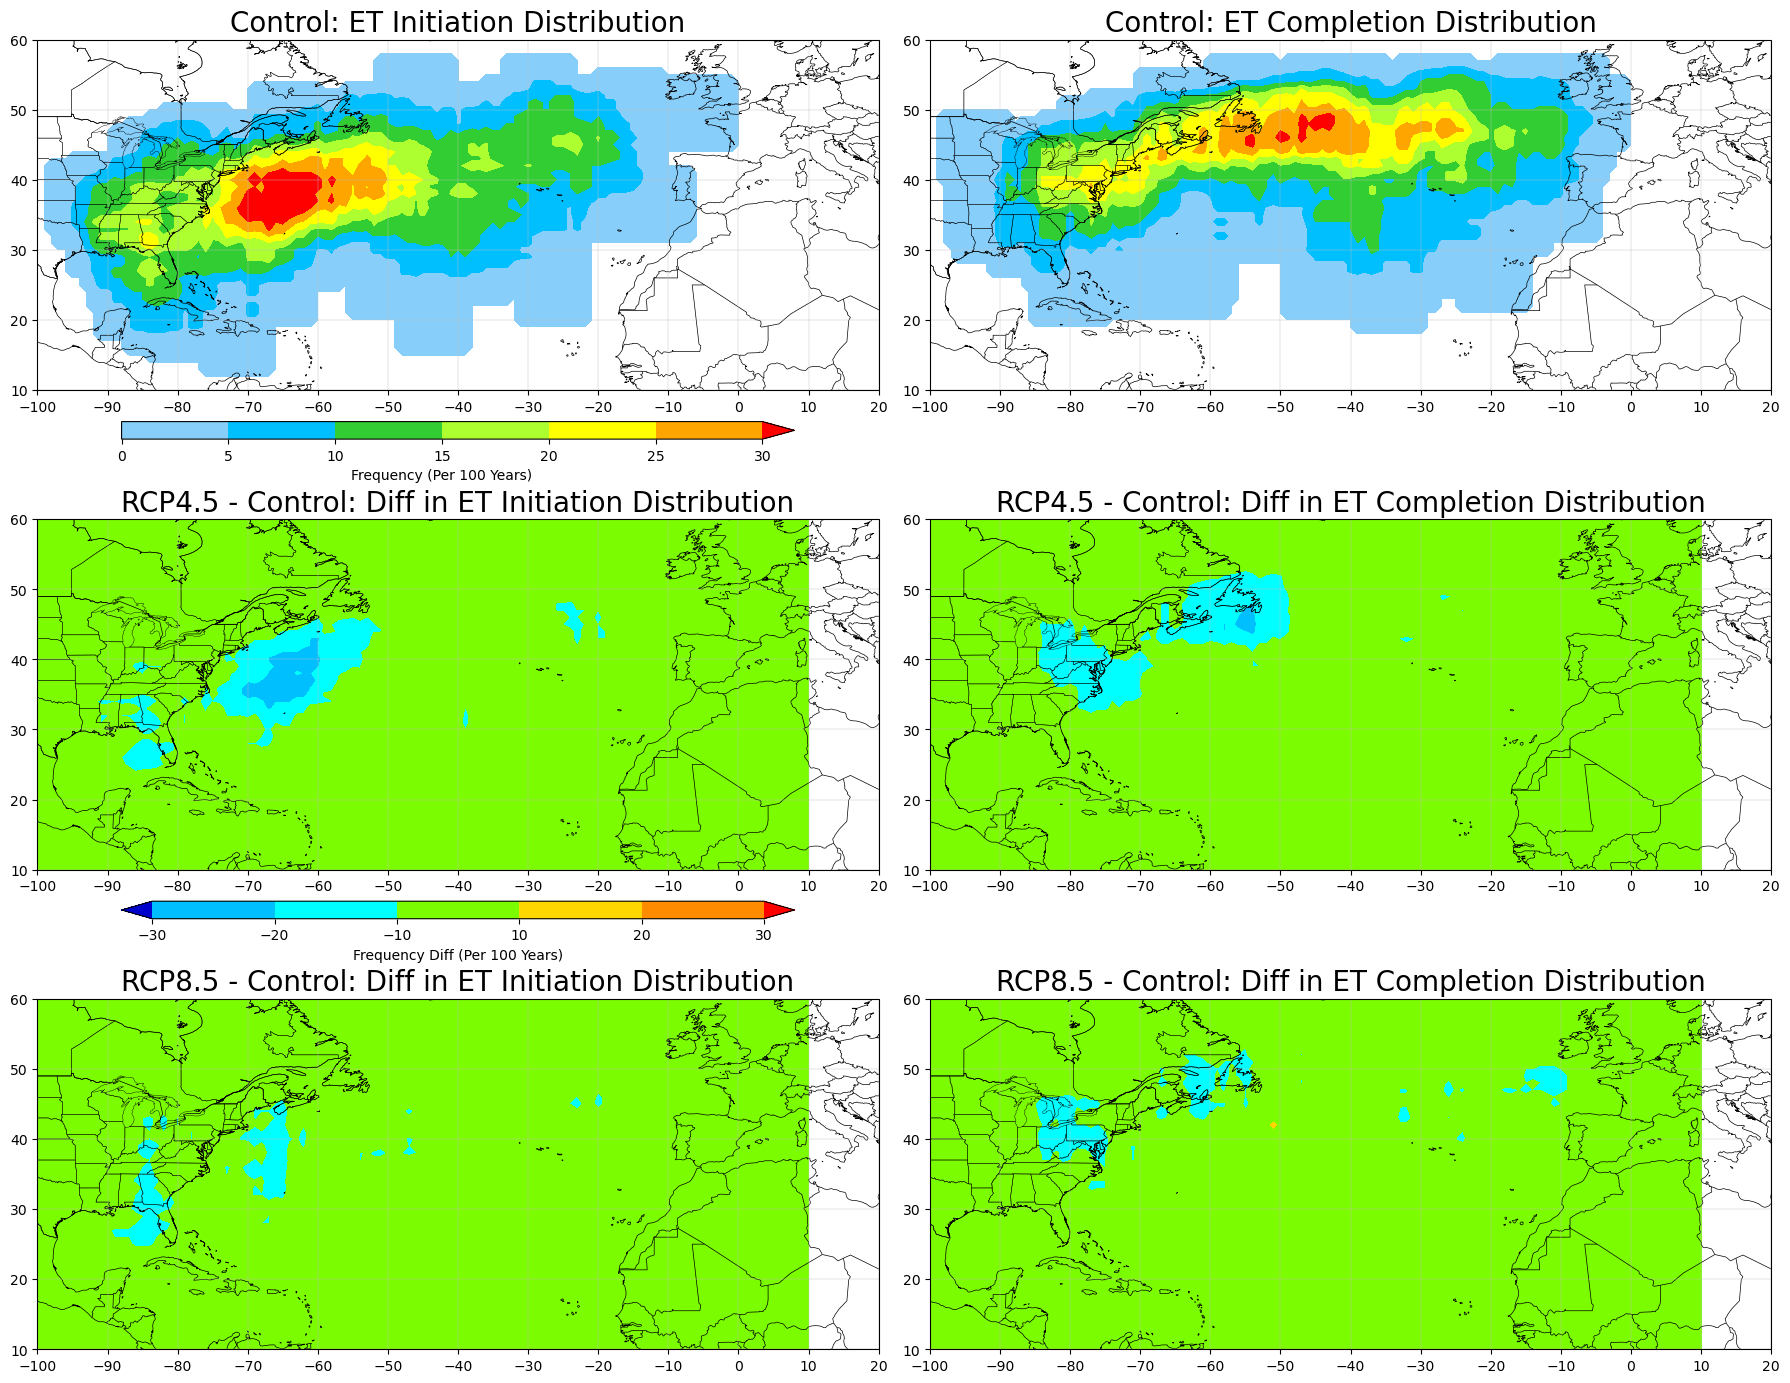

In [31]:
# Plot Differences Between ET Initiation and Completion Spatial Distributions (Annual)
Fig = pyplot.figure(figsize=(18,14))
ET_Distr_Plot(Control_ET, "Control", False, 0, True)
ET_Diff_Plot(RCP45_ET, Control_ET, "RCP4.5", "Control", False, 1, True)
ET_Diff_Plot(RCP85_ET, Control_ET, "RCP8.5", "Control", False, 2, False)
Fig.tight_layout()
Fig.savefig(Output_Diri+'ET_Diff_Annual.png', bbox_inches='tight')